In [ ]:
'''
Notebook dedicado à implementação e teste da AlexNet
https://www.youtube.com/watch?v=8GheVe2UmUM
../references/ImageNet Classification with Deep ConvolutionalNeural Networks.pdf

'''

In [ ]:
'''
Escrever função que organiza aleatoriamente os arquivos em pastas
Pastas: train, valid e test

Cada classe terá o mesmo número de exemplos. Avaliar possibilidade de copiar ao invés de mover.
Dica: files_distribution = [[long, n_long]],
                            [short, n_short],
                            [wait, n_wait]]
      for class in files_distribution:
          for file in random.sample(glob.glob(class[0] + '.*'), class[1]):
              shutil.move(file, '/charts/' + class[0])
'''

In [1]:
from pathlib import Path
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import random
import glob
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import matplotlib.pyplot as plt


class AssetNotFoundError(OSError):
    pass


In [4]:
'''
Parâmetros
'''

steps = ['train', 'valid', 'test']
asset = 'BTOW3'
classes = ['long', 'short', 'wait']
samples_sizes = [501, 150, 150]

data_path = Path(f'./generated_data/{asset}')


In [5]:
indicator = ' <- Insuficient images'
print('class: available / needed\n')
for classification in classes:
    search_str = str(data_path/f'*{classification}*')
    search_res = glob.glob(search_str)
    warning = ''
    if len(search_res) < sum(samples_sizes):
        warning = indicator
    print(f'{classification}: {str(len(search_res))} / {sum(samples_sizes)}{warning}')

class: available / needed

long: 1225 / 801
short: 1304 / 801
wait: 806 / 801


In [6]:
'''
Idendificação e configuração da GPU
'''

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs available:  1


In [7]:
'''
Cria as pastas de treinamento, validação e teste com as classes indicadas caso ainda não existam
'''

if not Path.is_dir(data_path):
    raise AssetNotFoundError('Asset folder not found.')

for step in steps:
    step_path = Path(data_path/step)
    step_path.mkdir(exist_ok=True)
    for classification in classes:
        classification_path = Path(step_path/classification)
        classification_path.mkdir(exist_ok=True)
print('Folder structure created.')


Folder structure created.


In [8]:
'''
Seleciona aleatoriamente os gráficos que serão usados nas etapas de treinamento, velidação e teste e os move para as pastas correspondentes
As amostras são colhidas de forma equilibrada
'''

for i in range(0,len(steps)):
    step_path = Path(data_path/steps[i])
    for classification in classes:
        classification_path = Path(step_path/classification)
        search_str = str(data_path/f'*{classification}*')
        for chart in random.sample(glob.glob(search_str), samples_sizes[i]):
            shutil.move(chart, classification_path)
print('Images moved to destination folders.')


Images moved to destination folders.


In [11]:
rescale = 1/255
target_size = (300, 300)
batch_size = 64
class_mode = 'categorical'

train_datagen = ImageDataGenerator(rescale=rescale)
train_batches = train_datagen.flow_from_directory(f'{data_path}/train',
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode=class_mode)

test_datagen = ImageDataGenerator(rescale=rescale)
test_batches = train_datagen.flow_from_directory(f'{data_path}/test',
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode=class_mode)

valid_datagen = ImageDataGenerator(rescale=rescale)
valid_batches = train_datagen.flow_from_directory(f'{data_path}/valid',
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode=class_mode)


Found 1503 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


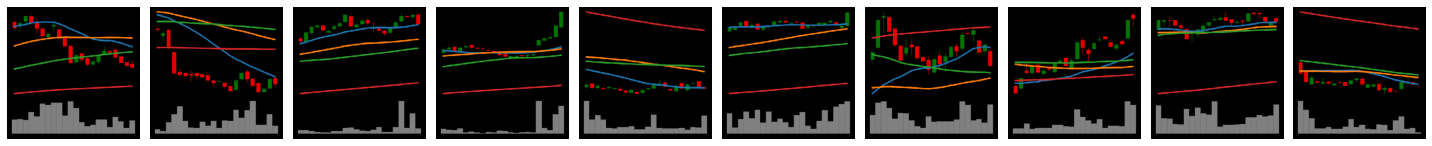

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [12]:
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels[0:9])

In [13]:
model = Sequential([
        Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(target_size[0], target_size[1], 3)),
        MaxPool2D(pool_size=2, strides=2),
        Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPool2D(pool_size=2, strides=2),
        Flatten(),
        Dense(units=3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 360000)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1080003   
Total params: 1,099,395
Trainable params: 1,099,395
Non-trainable params: 0
______________________________________________

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=20)

Epoch 1/20
24/24 [==============================] - 11s 457ms/step - loss: 1.0007 - accuracy: 0.5323 - val_loss: 1.1151 - val_accuracy: 0.3556
Epoch 2/20
24/24 [==============================] - 6s 268ms/step - loss: 0.9068 - accuracy: 0.6188 - val_loss: 1.1427 - val_accuracy: 0.3822
Epoch 3/20
24/24 [==============================] - 6s 270ms/step - loss: 0.7910 - accuracy: 0.6953 - val_loss: 1.2165 - val_accuracy: 0.3756
Epoch 4/20
24/24 [==============================] - 6s 265ms/step - loss: 0.6936 - accuracy: 0.7352 - val_loss: 1.2636 - val_accuracy: 0.3844
Epoch 5/20
24/24 [==============================] - 6s 265ms/step - loss: 0.5808 - accuracy: 0.7997 - val_loss: 1.3075 - val_accuracy: 0.3689
Epoch 6/20
24/24 [==============================] - 6s 266ms/step - loss: 0.4762 - accuracy: 0.8516 - val_loss: 1.3875 - val_accuracy: 0.3867
Epoch 7/20
24/24 [==============================] - 6s 265ms/step - loss: 0.3836 - accuracy: 0.8975 - val_loss: 1.5018 - val_accuracy: 0.3711
Epoch

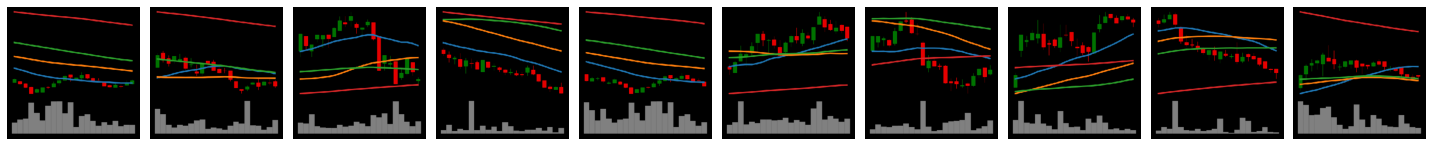

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [17]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels[0:9])

In [18]:
predictions = model.predict(x=test_batches)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))


In [19]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [20]:
test_batches.class_indices

{'long': 0, 'short': 1, 'wait': 2}

Confusion matrix, without normalization
[[53 42 55]
 [54 44 52]
 [41 36 73]]


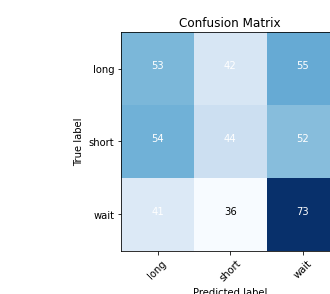

In [21]:
cm_plot_labels = ['long', 'short', 'wait']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')